涉及寻找最优权重参数的最优化方法、权重参数的初始值，超参数的设定方法等，
为了应对过拟合，学习权值衰减，Dropout等正则化方法，并进行实现，
学习Batch Normalization 方法，通过这些方法可以高效的进行神经网络的学习，提高识别精度。

- 1、参数的更新
- 2、权重的的初始值
- 3、Batch Normalization
- 4、正则化
- 5、超参数的验证


### 一、参数的更新


神经网络的学习目的是找到使损失函数的值尽可能小的参数，这是寻找最优参数的问题，解决这个问题的过程称为最优化。

随机梯度下降法（stochastic gradient descent），简称SGD
    
$$
W = W - \eta \frac{\partial L}{\partial W}
$$
式中，$W$是权重参数，$\eta$是学习率，$\frac{\partial L}{\partial W}$是损失函数关于权重参数的导数。
SGD是朝着梯度方向只前进一定距离的简单方法

In [ ]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr              #学习率
        
    def update(self, params, grads):
        for key in params.keys():
            params[key] -= self.lr * grads[key]

update（params,grads） 方法在SGD中被反复调用，参数params 和 grads 是字典型变量，按params['W1']、grads['W1']的形式，分别保存了权重参数和它们的梯度。使用SGD这个类，可以像下面这样更新权重参数。
```
# 假设神经网络有2层
network = TwoLayerNet(...)
optimizer = SGD()           #参数的更新由optimizer负责完成，需要做的只是将参数和梯度的信息传给optimizer

for i in range(10000):
    ...
    # 进行mini-batch学习
    x_batch, t_batch = get_mini_batch(...)  # mini-batch
    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)
    ...
```

通过单独实现进行最优化的类，功能的模块化变得简单，如果要实现另外一个最优化Momentum，它同样会实现成拥有update(params, grads)这个共同方法的形式。这样一来，只需要将optimizer = SGD()这一语句换成optimizer = Momentum()，就可以从SGD切换为Momentum。

SGD的缺点：
- 学习率lr是固定值，不能自动调整。
- 不能保证到达最小值。
- 可能被困在鞍点（saddle point）。

为了改正SGD 将介绍Momentum、AdaGrad、Adam 这3种方法来取代SGD

Momentum 动量法
公式
$$
v = \alpha v - \eta \frac{\partial L}{\partial W} \\
W = W + v
$$
其中，$v$是速度，$\alpha$是动量系数，$\eta$是学习率，$\frac{\partial L}{\partial W}$是损失函数关于权重$W$的梯度。


In [ ]:
class Momentum:
    def __init__(self, lr=0.01, momentum=0.9):
        self.lr = lr
        self.momentum = momentum
        self.v = None

    def update(self, params, grads):
        if self.v is None:
            self.v = {}
            for key, val in params.items():
                self.v[key] = np.zeros_like(val)
        for key in params.keys():
            self.v[key] = self.momentum*self.v[key] - self.lr*grads[key]
            params[key] += self.v[key]

实例变量v会保存物体的速度。初始化时，v中什么都不保存，但当第一次调用update()时，v会以字典型变量的形式保存与参数结构相同的数据。

Adagrad 

Adagrad 是一个针对学习率进行自适应调整的方法。学习率过小，会导致学习花费过多时间，学习率过大，会导致学习发散而不能正确进行。

在关于学习率的有效技巧中，有一种被称为学习率衰减（learning rate decay）的方法。学习率衰减是指随着学习的进行，学习率逐渐减小的方法。这样做的目的是为了在学习开始时，使学习率较大，从而快速学习；而在学习结束时，使学习率较小，从而使学习更加稳定,逐渐减小学习率的想法，相当于将全体参数的学习率值一起降低而AdaGrad进一步发展了这个想法，针对“一个一个”的参数，赋予其“定制”的值。

AdaGrad会为参数的每个元素适当地调整学习率，与此同时进行学习（AdaGrad的Ada来自英文单词Adaptive，即“适当的”的意思）。下面，让我们用数学式表示AdaGrad的更新方法。

公式
$$
h = h + \frac{\partial L}{\partial W} \odot \frac{\partial L}{\partial W} \\
W = W - \eta \frac{1}{\sqrt{h}} \odot \frac{\partial L}{\partial W}
$$
其中，$h$是累加的梯度的平方和，$\eta$是学习率，$\odot$是按元素相乘的运算符。
变量h保存了以前所有梯度值的平方和，参数的元素中变动较大（被大幅更新）的元素的学习率将变小。也就是说，可以按参数的元素进行学习率衰减，使变动大的参数的学习率逐渐减小。


In [ ]:
class Adagrad:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.h = None
    def update(self, params, grads):
        if self.h is None:
            self.h = {}
            for key, val in params.items():
                self.h[key] = np.zeros_like(val)
        for key in params.keys():
            self.h[key] += grads[key] * grads[key]
            params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)

这里需要注意的是，最后一行加上了微小值1e-7。这是为了防止当self.h[key]中有0时，将0用作除数的情况。在很多深度学习的框架中，这个微小值也可以设定为参数，但这里我们用的是1e-7这个固定值。

Adam
公式
$$
m_t = \beta_1 m_{t-1} + (1 - \beta_1) \triangledown \theta_t
$$
$$
v_t = \beta_2 v_{t-1} + (1 - \beta_2) \triangledown \theta_t^2
$$
$$
\theta_t = \theta_{t-1} - \frac{\alpha \sqrt{1 - \beta_2^t}}{1 - \beta_1^t} \frac{m_t}{\sqrt{v_t} + \epsilon}
$$


Momentum参照小球在碗中滚动的物理规则进行移动，AdaGrad为参数的每个元素适当地调整更新步伐。如果将这两个方法融合在一起会怎么样?
它的理论有些复杂，直观地讲，就是融合了Momentum和AdaGrad的方法。通过组合前面两个方法的优点，有望实现参数空间的高效搜索。此外，进行超参数的“偏置校正”也是Adam的特征。


Adam会设置3个超参数。一个是学习率（论文中以α出现），另外两个是一次momentum系数β1和二次momentum系数β2。根据论文，标准的设定值是β1为0.9，β2为0.999。设置了这些值后，大多数情况下都能顺利运行。

In [ ]:
class Adam:
    def __init__(self, lr=0.001, beta1=0.9, beta2=0.999):
        self.lr = lr
        self.beta1 = beta1
        self.beta2 = beta2
        self.iter = 0
        self.m = None
        self.v = None
    def update(self, params, grads):
        if self.m is None:
            self.m, self.v = {}, {}
            for key, val in params.items():
                self.m[key] = np.zeros_like(val)
                self.v[key] = np.zeros_like(val)
        self.iter += 1
        lr_t = self.lr * np.sqrt(1.0 - self.beta2**self.iter) / (1.0 - self.beta1**self.iter)
        for key in params.keys():
            self.m[key] += (1 - self.beta1) * (grads[key] - self.m[key])
            self.v[key] += (1 - self.beta2) * (grads[key]**2 - self.v[key])


以上为4种更新权重参数的方法，用代码比较一下各个方法：

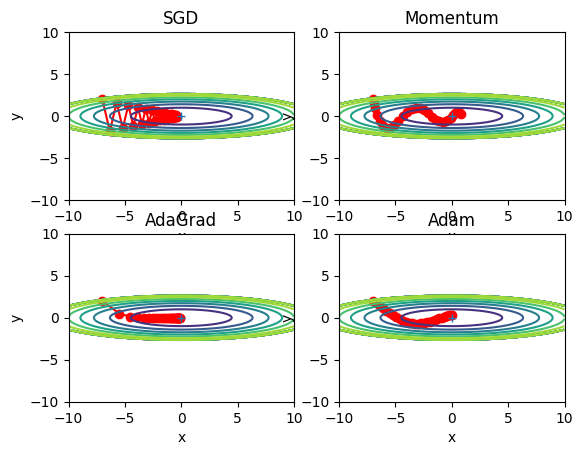

In [1]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict
from common.optimizer import *


def f(x, y):
    return x**2 / 20.0 + y**2


def df(x, y):
    return x / 10.0, 2.0*y

init_pos = (-7.0, 2.0)
params = {}
params['x'], params['y'] = init_pos[0], init_pos[1]
grads = {}
grads['x'], grads['y'] = 0, 0


optimizers = OrderedDict()
optimizers["SGD"] = SGD(lr=0.95)
optimizers["Momentum"] = Momentum(lr=0.1)
optimizers["AdaGrad"] = AdaGrad(lr=1.5)
optimizers["Adam"] = Adam(lr=0.3)

idx = 1

for key in optimizers:
    optimizer = optimizers[key]
    x_history = []
    y_history = []
    params['x'], params['y'] = init_pos[0], init_pos[1]
    
    for i in range(30):
        x_history.append(params['x'])
        y_history.append(params['y'])
        
        grads['x'], grads['y'] = df(params['x'], params['y'])
        optimizer.update(params, grads)
    

    x = np.arange(-10, 10, 0.01)
    y = np.arange(-5, 5, 0.01)
    
    X, Y = np.meshgrid(x, y) 
    Z = f(X, Y)
    
    # for simple contour line  
    mask = Z > 7
    Z[mask] = 0
    
    # plot 
    plt.subplot(2, 2, idx)
    idx += 1
    plt.plot(x_history, y_history, 'o-', color="red")
    plt.contour(X, Y, Z)
    plt.ylim(-10, 10)
    plt.xlim(-10, 10)
    plt.plot(0, 0, '+')
    #colorbar()
    #spring()
    plt.title(key)
    plt.xlabel("x")
    plt.ylabel("y")
    
plt.show()

如图所示，根据使用的方法不同，参数更新的路径也不同。根据需要解决的问题而变，并且超参数（学习率）的设定值不同，结果也会发生变化。
4种方法中并不存在能在所有问题中都表现良好的方法，4种方法各有各的特点，都有各自擅长解决的问题和不擅长解决的问题。

基于MNIST数据集的更新方法比较

===========iteration:0===========
SGD:2.334465923864478
Momentum:2.456840855346833
AdaGrad:2.133047128202575
Adam:2.191414032146696
===========iteration:100===========
SGD:1.4806365218221864
Momentum:0.31749043192181964
AdaGrad:0.10854910137480854
Adam:0.20030612049045027
===========iteration:200===========
SGD:0.9065042501182607
Momentum:0.3466490163360072
AdaGrad:0.13605168091662206
Adam:0.2748783550289918
===========iteration:300===========
SGD:0.6075401644189193
Momentum:0.18417674374945545
AdaGrad:0.06642956918322188
Adam:0.08094718246627797
===========iteration:400===========
SGD:0.31187653394387105
Momentum:0.17621444597777644
AdaGrad:0.09361110841860612
Adam:0.13167737758596693
===========iteration:500===========
SGD:0.4610321198841786
Momentum:0.1754745441920862
AdaGrad:0.0704557988322967
Adam:0.11671591757943592
===========iteration:600===========
SGD:0.24399520434690886
Momentum:0.06694925760613218
AdaGrad:0.03947457936413654
Adam:0.03906271495744526
===========iteration:700

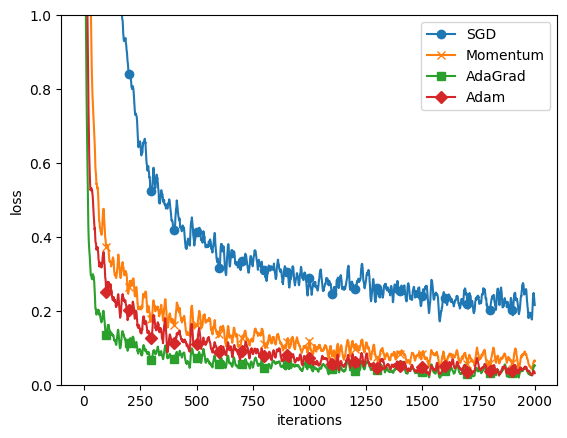

In [2]:
# coding: utf-8
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import matplotlib.pyplot as plt
from digit_recognition.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import *


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
optimizers = {}
optimizers['SGD'] = SGD()
optimizers['Momentum'] = Momentum()
optimizers['AdaGrad'] = AdaGrad()
optimizers['Adam'] = Adam()
#optimizers['RMSprop'] = RMSprop()

networks = {}
train_loss = {}
for key in optimizers.keys():
    networks[key] = MultiLayerNet(
        input_size=784, hidden_size_list=[100, 100, 100, 100],
        output_size=10)
    train_loss[key] = []    


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in optimizers.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizers[key].update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print( "===========" + "iteration:" + str(i) + "===========")
        for key in optimizers.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {"SGD": "o", "Momentum": "x", "AdaGrad": "s", "Adam": "D"}
x = np.arange(max_iterations)
for key in optimizers.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 1)
plt.legend()
plt.show()



以上实验是一个5层神经网络为对象，其中每层有100个神经元。激活函数使用的是Relu.

与SGD相比，其他3种方法学习得更快，而且速度基本相同，仔细看的话，AdaGrad的学习进行得稍微快一点。这个实验需要注意的地方是，实验结果会随学习率等超参数、神经网络的结构（几层深等）的不同而发生变化。不过，一般而言，与SGD相比，其他3种方法可以学习得更快，有时最终的识别精度也更高。



### 二、权重的初始值

权重的初始值很重要。设定什么么样的初始值，经常关系到神经网络的学习能否成功。下面学习权重初始值的推荐值，并通过实验确认神经网络的学习是否会快速进行。

权值衰减：一种以减小权值参数的值为目的进行学习的方法。通过减小权重参数的值来抑制过拟合的发生。

如果想减小权重的值，一开始就将初始值设为较小的值。将权重初始值设置为0的话，将无法正确进行学习。严格的说，权重初始值不能设置为一样的值。

因为在误差反向传播法中，所有的权重值都会进行相同的更新。比如，在2层神经网络中，假设第1层和第2层的权重为0。这样一来，正向传播时，因为输入层的权重为0，所以第2层的神经元全部会被传递相同的值。第2层的神经元中全部输入相同的值，这意味着反向传播时第2层的权重全部都会进行相同的更新（回忆一下“乘法节点的反向传播”的内容）。因此，权重被更新为相同的值，并拥有了对称的值（重复的值）。这使得神经网络拥有许多不同的权重的意义丧失了。为了防止“权重均一化”（严格地讲，是为了瓦解权重的对称结构），必须随机生成初始值。

隐藏层的激活值分布

观察隐藏层的激活值（激活函数的输出数据）的分布，可以获得很多启发。这里，我们来做一个简单的实验，观察权重初始值是如何影响隐藏层的激活值的分布的。这里要做的实验是，向一个5层神经网络（激活函数使用sigmoid函数）传入随机生成的输入数据，用直方图绘制各层激活值的数据分布。

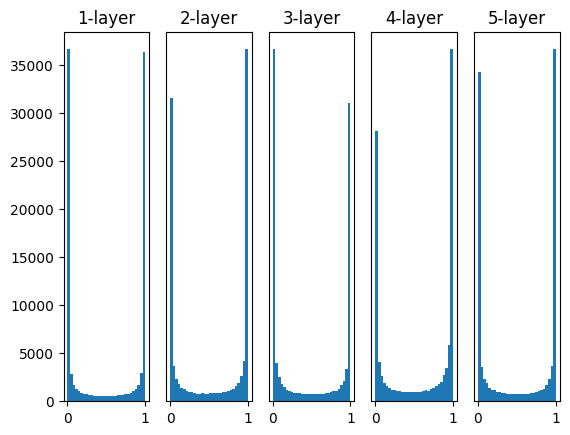

In [ ]:
# coding: utf-8
import numpy as np
import matplotlib.pyplot as plt


def sigmoid(x):
    return 1 / (1 + np.exp(-x))


def ReLU(x):
    return np.maximum(0, x)


def tanh(x):
    return np.tanh(x)     # 激活函数的输出值分布在-1.0到1.0之间，0附近的地方最敏感。
    
input_data = np.random.randn(1000, 100)  # 1000个数据
node_num = 100  # 各隐藏层的节点（神经元）数
hidden_layer_size = 5  # 隐藏层有5层
activations = {}  # 激活值的结果保存在这里

x = input_data

for i in range(hidden_layer_size):
    if i != 0:
        x = activations[i-1]

    # 改变初始值进行实验！
    w = np.random.randn(node_num, node_num) * 1                                  # 标准差为1的高斯分布
    #w = np.random.randn(node_num, node_num) * 0.01                              # 标准差为0.01的高斯分布
    #w = np.random.randn(node_num, node_num) * np.sqrt(1.0 / node_num)           # Xavier初始值
    #w = np.random.randn(node_num, node_num) * np.sqrt(2.0 / node_num)           # He初始值


    a = np.dot(x, w)


    # 将激活函数的种类也改变，来进行实验！
    z = sigmoid(a)
    # z = ReLU(a)
    # z = tanh(a)

    activations[i] = z   # 保存第i层的激活值

# 绘制直方图
for i, a in activations.items():
    plt.subplot(1, len(activations), i+1)
    plt.title(str(i+1) + "-layer")
    if i != 0: plt.yticks([], [])
    # plt.xlim(0.1, 1)
    # plt.ylim(0, 7000)
    plt.hist(a.flatten(), 30, range=(0,1))
plt.show()


使用标准差为1的高斯分布作为权重初始值时

    各层的激活值呈偏向0和1的分布。这里使用的sigmoid 函数是S型函数，随着输出不断地靠近0（或者靠近1），它的导数的值逐渐接近0。因此，偏向0和1的数据分布会造成反向传播中梯度的值不断变小，最后消失。这个问题称为梯度消失（gradient vanishing）。层次加深的深度学习中，梯度消失的问题可能会更加严重。

使用标准差为0.01的高斯分布作为权重初始值时
    
    这次呈集中在0.5附近的分布。因为不像刚才的例子那样偏向0和1，所以不会发生梯度消失的问题。但是，激活值的分布有所偏向，说明在表现力上会有很大问题。为什么这么说呢？因为如果有多个神经元都输出几乎相同的值，那它们就没有存在的意义了。比如，如果100个神经元都输出几乎相同的值，那么也可以由1个神经元来表达基本相同的事情。因此，激活值在分布上有所偏向会出现“表现力受限”的问题。

        各层的激活值的分布都要求有适当的广度。为什么呢？因为通过在各层间传递多样性的数据，神经网络可以进行高效的学习。反过来，如果传递的是有所偏向的数据，就会出现梯度消失或者“表现力受限”的问题，导致学习可能无法顺利进行。


Xavier初始值
    
    现在，在一般的深度学习框架中，Xavier初始值已被作为标准使用。比如，Cafe框架中，通过在设定权重初始值时赋予xavier参数，就可以使用Xavier初始值。

    Xavier的论文中，为了使各层的激活值呈现出具有相同广度的分布，推导出了一个合适的权重尺度，即服从均匀分布的随机数。
    推导出的结论是，如果前一层的节点数为n，则权重W初始值使用标准差为  根号1/n  的分布

    使用Xavier初始值后的结果可知，越是后面的层，图像变得越歪斜，但是呈现了比之前更有广度的分布。因为各层间传递的数据有适当的广度，所以sigmoid函数的表现力不受限制，有望进行高效的学习。
    
    后面的层的分布呈稍微歪斜的形状。如果用tanh 函数（双曲线函数）代替sigmoid函数，这个稍微歪斜的问题就能得到改善。实际上，使用tanh函数后，会呈漂亮的吊钟型分布。tanh 函数和sigmoid函数同是S型曲线函数，但tanh函数是关于原点(0,0)对称的S型曲线，而sigmoid函数是关于(x,y)=(0,0.5)对称的S型曲线。众所周知，用作激活函数的函数最好具有关于原点对称的性质。


He初始值

    Xavier初始值是以激活函数是线性函数为前提而推导出来的。因为sigmoid函数和tanh函数左右对称，且中央附近可以视作线性函数，所以适合使用Xavier初始值。但当激活函数使用ReLU时，一般推荐使用ReLU专用的初始值，也就是Kaiming He等人推荐的初始值，也称为“He初始值”

    当前一层的节点数为n时，He初始值使用标准差为  根号2/n  的高斯分布 当Xavier初始值是根号1/n 时，直观上可以解释为因为RELU的负值区域的值为0，为了使他更有广度，所以需要2倍的系数。

可以用代码查看激活函数使用ReLU时,不同权重初始值的激活值分布的变化

观察实验结果可知，当“std=0.01”时，各层的激活值非常小A。神经网络上传递的是非常小的值，说明逆向传播时权重的梯度也同样很小。这是很严重的问题，实际上学习基本上没有进展。

接下来是初始值为Xavier初始值时的结果。在这种情况下，随着层的加深，偏向一点点变大。实际上，层加深后，激活值的偏向变大，学习时会出现梯度消失的问题。而当初始值为He初始值时，各层中分布的广度相同。由于即便层加深，数据的广度也能保持不变，因此逆向传播时，也会传递合适的值。

总结一下，当激活函数使用ReLU时，权重初始值使用He初始值，当激活函数为sigmoid或tanh等S型曲线函数时，初始值使用Xavier初始值。这是目前的最佳实践。

基于MNIST数据集的权重初始值的比较

===========iteration:0===========
std=0.01:2.3025452793223105
Xavier:2.3127826725978133
He:2.2945635180653206
===========iteration:100===========
std=0.01:2.302196196938074
Xavier:2.2281802324403204
He:1.434016697619669
===========iteration:200===========
std=0.01:2.3024898555529116
Xavier:2.114267636008851
He:0.707238457309433
===========iteration:300===========
std=0.01:2.3022363309548624
Xavier:1.8548570733365763
He:0.516623651047761
===========iteration:400===========
std=0.01:2.304002550347861
Xavier:1.3142151168818823
He:0.38177963543642174
===========iteration:500===========
std=0.01:2.3037404071834047
Xavier:0.9062017672384095
He:0.4404924982009228
===========iteration:600===========
std=0.01:2.3006773032975936
Xavier:0.609532006303974
He:0.3167082083916421
===========iteration:700===========
std=0.01:2.2973419000125457
Xavier:0.5625253275963247
He:0.3962861758191965
===========iteration:800===========
std=0.01:2.2990591416740385
Xavier:0.4786930357527844
He:0.32313465128193497

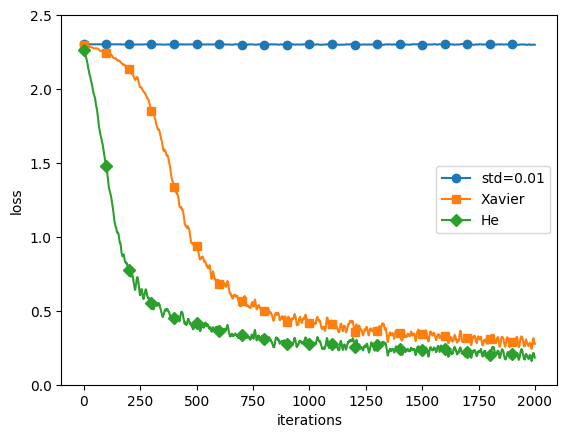

In [8]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from digit_recognition.mnist import load_mnist
from common.util import smooth_curve
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD


# 0:读入MNIST数据==========
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

train_size = x_train.shape[0]
batch_size = 128
max_iterations = 2000


# 1:进行实验的设置==========
weight_init_types = {'std=0.01': 0.01, 'Xavier': 'sigmoid', 'He': 'relu'}
optimizer = SGD(lr=0.01)

networks = {}
train_loss = {}
for key, weight_type in weight_init_types.items():
    networks[key] = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100],
                                  output_size=10, weight_init_std=weight_type)
    train_loss[key] = []


# 2:开始训练==========
for i in range(max_iterations):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]
    
    for key in weight_init_types.keys():
        grads = networks[key].gradient(x_batch, t_batch)
        optimizer.update(networks[key].params, grads)
    
        loss = networks[key].loss(x_batch, t_batch)
        train_loss[key].append(loss)
    
    if i % 100 == 0:
        print("===========" + "iteration:" + str(i) + "===========")
        for key in weight_init_types.keys():
            loss = networks[key].loss(x_batch, t_batch)
            print(key + ":" + str(loss))


# 3.绘制图形==========
markers = {'std=0.01': 'o', 'Xavier': 's', 'He': 'D'}
x = np.arange(max_iterations)
for key in weight_init_types.keys():
    plt.plot(x, smooth_curve(train_loss[key]), marker=markers[key], markevery=100, label=key)
plt.xlabel("iterations")
plt.ylabel("loss")
plt.ylim(0, 2.5)
plt.legend()
plt.show()

这个实验中，神经网络有5层，每层有100个神经元，激活函数使用的是ReLU。从图的结果可知，std=0.01时完全无法进行学习。这和刚才观察到的激活值的分布一样，是因为正向传播中传递的值很小（集中在0 附近的数据）。因此，逆向传播时求到的梯度也很小，权重几乎不进行更新。相反，当权重初始值为Xavier初始值和He初始值时，学习进行得很顺利。并且，我们发现He初始值时的学习进度更快一些。

综上，在神经网络的学习中，权重初始值非常重要。很多时候权重初始值的设定关系到神经网络的学习能否成功。权重初始值的重要性容易被忽视，而任何事情的开始（初始值）总是关键的，因此在结束本节之际，再次强调一下权重初始值的重要性。

### 三、Batch Normalization 的算法

在上一节，我们观察了各层的激活值分布，并从中了解到如果设定了合
适的权重初始值，则各层的激活值分布会有适当的广度，从而可以顺利地进行学习。那么，为了使各层拥有适当的广度，“强制性”地调整激活值的分布会怎样呢？实际上，Batch Normalization方法就是基于这个想法而产生的。

Batch Norm 优点
- 可以使学习快速进行（可以使神经网络使用更大的学习率）
- 不那么依赖初始值（对初始值不那么神经质）
- 抑制过拟合（降低Dropout等的必要性）



Batch Norm的思路是调整各层的激活值分布使其拥有适当的广度。要向神经网络中插入对数据分布进行正规化的层，即Batch Normalization层，在激活层之前。

以进行学习时的mini-batch为单位进行正规化，计算mini-batch的均值和标准差，然后进行正规化。就是进行数据分布的均值为0，方差为1的正规化。

数学表达式为：
$$
x_{norm} = \frac{x - \mu}{\sqrt{\sigma^2 + \epsilon}}
$$
其中，$x$ 为输入数据，$\mu$ 为 mini-batch 的均值，$\sigma$ 为 mini-batch 的标准差，$\epsilon$ 为一个很小的数，防止除以 0。

正规化后的数据分布的均值为0，方差为1。

均值：
$$
\mu = \frac{1}{m} \sum_{i=1}^{m} x_i
$$
其中，$m$ 为 mini-batch 的大小，$x_i$ 为 mini-batch 中的第 $i$ 个数据。

方差：
$$
\sigma^2 = \frac{1}{m} \sum_{i=1}^{m} (x_i - \mu)^2
$$

这里对mini-batch的m个输入数据的集合B={x1,x2,...,xm}求均值和方差，然后对输入数据进行均值为0，方差为1的正规化。ε是一个微小值（比如，10e-7等），它是为了防止出现除以0的情况。

通过将这个处理插入到激活函数的前面（或者后面），可以减小数据分布的偏向。接着，Batch Norm层会对正规化后的数据进行缩放和平移的变换，用数学式可以如下表示：
$$
y = \gamma x_{norm} + \beta
$$
其中，$y$ 为输出数据，$\gamma$ 为缩放系数，$\beta$ 为平移系数，$x_{norm}$ 为正规化后的数据。

缩放系数和平移系数是可学习的参数，它们的初始值一般设为1和0。

以上为神经网络的Batch Norm层的正向传播处理，可以通过查阅资料学习BN的反向传播算法.

现在我们使用Batch Norm层进行实验。首先，使用MNIST数据集，观察使用Batch Norm层和不使用Batch Norm层时学习的过程会如何变化

In [ ]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from digit_recognition.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.optimizer import SGD, Adam

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 减少学习数据
x_train = x_train[:1000]
t_train = t_train[:1000]

max_epochs = 20
train_size = x_train.shape[0]
batch_size = 100
learning_rate = 0.01


def __train(weight_init_std):
    bn_network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10, 
                                    weight_init_std=weight_init_std, use_batchnorm=True)
    network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100], output_size=10,
                                weight_init_std=weight_init_std)
    optimizer = SGD(lr=learning_rate)
    
    train_acc_list = []
    bn_train_acc_list = []
    
    iter_per_epoch = max(train_size / batch_size, 1)
    epoch_cnt = 0
    
    for i in range(1000000000):
        batch_mask = np.random.choice(train_size, batch_size)
        x_batch = x_train[batch_mask]
        t_batch = t_train[batch_mask]
    
        for _network in (bn_network, network):
            grads = _network.gradient(x_batch, t_batch)
            optimizer.update(_network.params, grads)
    
        if i % iter_per_epoch == 0:
            train_acc = network.accuracy(x_train, t_train)
            bn_train_acc = bn_network.accuracy(x_train, t_train)
            train_acc_list.append(train_acc)
            bn_train_acc_list.append(bn_train_acc)
    
            print("epoch:" + str(epoch_cnt) + " | " + str(train_acc) + " - " + str(bn_train_acc))
    
            epoch_cnt += 1
            if epoch_cnt >= max_epochs:
                break
                
    return train_acc_list, bn_train_acc_list


# 3.绘制图形==========
weight_scale_list = np.logspace(0, -4, num=16)
x = np.arange(max_epochs)

for i, w in enumerate(weight_scale_list):
    print( "============== " + str(i+1) + "/16" + " ==============")
    train_acc_list, bn_train_acc_list = __train(w)
    
    plt.subplot(4,4,i+1)
    plt.title("W:" + str(w))
    if i == 15:
        plt.plot(x, bn_train_acc_list, label='Batch Normalization', markevery=2)
        plt.plot(x, train_acc_list, linestyle = "--", label='Normal(without BatchNorm)', markevery=2)
    else:
        plt.plot(x, bn_train_acc_list, markevery=2)
        plt.plot(x, train_acc_list, linestyle="--", markevery=2)

    plt.ylim(0, 1.0)
    if i % 4:
        plt.yticks([])
    else:
        plt.ylabel("accuracy")
    if i < 12:
        plt.xticks([])
    else:
        plt.xlabel("epochs")
    plt.legend(loc='lower right')
    
plt.show()

### 四、正则化

机器学习的问题中，过拟合是一个很常见的问题。过拟合指的是只能拟合训练数据，但不能很好地拟合不包含在训练数据中的其他数据的状态。机器学习的目标是提高泛化能力，即便是没有包含在训练数据里的未观测数据，也希望模型可以进行正确的识别。我们可以制作复杂的、表现力强的模型，但是相应地，抑制过拟合的技巧也很重要。

发生过拟合的原因：
1. 模型复杂度高：模型的参数过多，导致模型在训练数据上的表现很好，但是在测试数据上的表现不好。
2. 训练数据少：模型的参数过多，导致模型在训练数据上的表现很好，但是在测试数据上的表现不好。


我们故意满足这两个条件，制造过拟合现象。为此，要从MNIST数据集原本的60000个训练数据中只选定300个，并且，为了增加网络的复杂度，使用7层网络（每层有100个神经元，激活函数为ReLU）。

epoch:0, train acc:0.07666666666666666, test acc:0.0775
epoch:1, train acc:0.07666666666666666, test acc:0.0816
epoch:2, train acc:0.08666666666666667, test acc:0.0888
epoch:3, train acc:0.10666666666666667, test acc:0.101
epoch:4, train acc:0.13666666666666666, test acc:0.1147
epoch:5, train acc:0.16, test acc:0.1304
epoch:6, train acc:0.17666666666666667, test acc:0.1414
epoch:7, train acc:0.20333333333333334, test acc:0.1592
epoch:8, train acc:0.22333333333333333, test acc:0.1764
epoch:9, train acc:0.25666666666666665, test acc:0.1925
epoch:10, train acc:0.31333333333333335, test acc:0.2028
epoch:11, train acc:0.33666666666666667, test acc:0.2168
epoch:12, train acc:0.3566666666666667, test acc:0.2262
epoch:13, train acc:0.36, test acc:0.235
epoch:14, train acc:0.38666666666666666, test acc:0.2458
epoch:15, train acc:0.37333333333333335, test acc:0.2546
epoch:16, train acc:0.37666666666666665, test acc:0.2602
epoch:17, train acc:0.41333333333333333, test acc:0.2656
epoch:18, train a

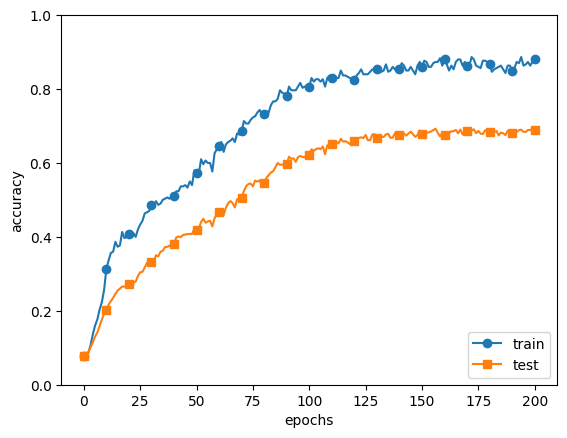

In [12]:
# coding: utf-8
import os
import sys

sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from digit_recognition.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.optimizer import SGD

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# weight decay（权值衰减）的设定 =======================
#weight_decay_lambda = 0 # 不使用权值衰减的情况
weight_decay_lambda = 0.1
# ====================================================

network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100], output_size=10,
                        weight_decay_lambda=weight_decay_lambda)
optimizer = SGD(lr=0.01)

max_epochs = 201
train_size = x_train.shape[0]
batch_size = 100

train_loss_list = []
train_acc_list = []
test_acc_list = []

iter_per_epoch = max(train_size / batch_size, 1)
epoch_cnt = 0

for i in range(1000000000):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grads = network.gradient(x_batch, t_batch)
    optimizer.update(network.params, grads)

    if i % iter_per_epoch == 0:
        train_acc = network.accuracy(x_train, t_train)
        test_acc = network.accuracy(x_test, t_test)
        train_acc_list.append(train_acc)
        test_acc_list.append(test_acc)

        print("epoch:" + str(epoch_cnt) + ", train acc:" + str(train_acc) + ", test acc:" + str(test_acc))

        epoch_cnt += 1
        if epoch_cnt >= max_epochs:
            break
# train_acc_list和test_acc_list中以epoch为单位（看完了所有训练数据的单位）保存识别精度

# 3.绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(max_epochs)
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

过了100个epoch左右后，用训练数据测量到的识别精度几乎都为100%。但是，对于测试数据，离100%的识别精度还有较大的差距。如此大的识别精度差距，是只拟合了训练数据的结果。从图中可知，模型对训练时没有使用的一般数据（测试数据）拟合得不是很好。

权值衰减

    权值衰减是一直以来经常被使用的一种抑制过拟合的方法。该方法通过在学习的过程中对大的权重进行惩罚，来抑制过拟合。很多过拟合原本就是因为权重参数取值过大才发生的。对于所有权重，权值衰减方法都会为损失函数加上权重的L2范数惩罚。

    神经网络的学习中，目标是减小损失函数的值。也就是说，权重参数的目标是使损失函数的值尽可能小。为了减小损失函数的值，权重参数需要通过学习进行调整。但是，如果权重参数的取值过大，那么损失函数的值就会变得很大。这是因为权重参数的平方和越大，损失函数的值就越大。这时，例如为损失函数加上权重的平方范数（L2范数）。这样一来，就可以抑制权重变大。

    
    
    用符号表示的话，如果将权重记为W，L2范数的权值衰减就是 
$$L2 = \frac{1}{2}\lambda \|W\|^2$$
    然后将这个结果加到损失函数上，λ是控制正则化强度的超参数。这个超参数用来控制正则化的强度。λ值设置的越大，对大的权重施加的惩罚就越重，开头的1/2 是用于将求导结果变成λW的调整用常量，对于所有权重，权值衰减方法都会为损失函数加上1/2 * λW 因此，在求权重梯度的计算中，要为之前的误差反向传播法的结果加上正则化项的导数λW
    
    
    

Dropout

    作为抑制过拟合的方法，前面我们介绍了为损失函数加上权重的L2范数的权值衰减方法。该方法可以简单地实现，在某种程度上能够抑制过拟合。但是，如果网络的模型变得很复杂，只用权值衰减就难以应对了。在这种情况下，我们经常会使用Dropout方法。

    Dropout是一种正则化方法，用于减少神经网络的过拟合。它的工作原理是在训练过程中随机地将一部分神经元从网络中暂时“删除”，这样可以减少神经元之间的复杂 co-adaptation 关系，从而提高网络的泛化能力。训练时，随机选出隐藏层的神经元，然后将其删除。被删除的神经元不再进行信号的传递，如图6-22所示。训练时，每传递一次数据，就会随机选择要删除的神经元。然后，测试时，虽然会传递所有的神经元信号，但是对于各个神经元的输出，要乘上训练时的删除比例后再输出。

In [ ]:
class Dropout:
    def __init__(self, dropout_ratio=0.5):        
        self.dropout_ratio = dropout_ratio        
        self.mask = None

    def forward(self, x, train_flg=True):
        if train_flg:
            self.mask = np.random.rand(*x.shape) > self.dropout_ratio             
            return x * self.mask
        else:
            return x * (1.0 - self.dropout_ratio)
    def backward(self, dout):
        return dout * self.mask

这里的要点是，每次正向传播时，self.mask中都会以False的形式保存要删除的神经元。self.mask会随机生成和x形状相同的数组，并将值比dropout_ratio大的元素设为True。反向传播时的行为和ReLU相同。也就是说，正向传播时传递了信号的神经元，反向传播时按原样传递信号；正向传播时没有传递信号的神经元，反向传播时信号将停在那里。

train loss:2.319746882659066
=== epoch:1, train acc:0.07333333333333333, test acc:0.0902 ===
train loss:2.3286157950562894
train loss:2.3163961372123154
train loss:2.3240734913803003
=== epoch:2, train acc:0.06666666666666667, test acc:0.0896 ===
train loss:2.329893204613706
train loss:2.3294494606088088
train loss:2.309867878582897
=== epoch:3, train acc:0.07, test acc:0.0898 ===
train loss:2.3208739676486676
train loss:2.328717854160077
train loss:2.3099855735705113
=== epoch:4, train acc:0.07, test acc:0.0902 ===
train loss:2.3189041999680966
train loss:2.3164531633095122
train loss:2.2983664195850344
=== epoch:5, train acc:0.07, test acc:0.0901 ===
train loss:2.316040497928244
train loss:2.3148143783317
train loss:2.3200883186016794
=== epoch:6, train acc:0.06333333333333334, test acc:0.0917 ===
train loss:2.3063791598030865
train loss:2.3117214283139744
train loss:2.3020526217937136
=== epoch:7, train acc:0.06666666666666667, test acc:0.0936 ===
train loss:2.3006403260963957
train

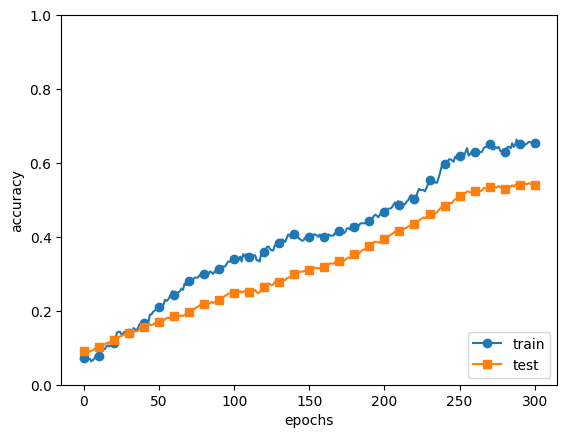

In [ ]:
# coding: utf-8
#使用7层网络（每层有100个神经元，激活函数为ReLU）设置为使用dropout
import os
import sys
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from digit_recognition.mnist import load_mnist
from common.multi_layer_net_extend import MultiLayerNetExtend
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了再现过拟合，减少学习数据
x_train = x_train[:300]
t_train = t_train[:300]

# 设定是否使用Dropuout，以及比例 ========================
use_dropout = True  # 不使用Dropout的情况下为False
dropout_ratio = 0.2
# ====================================================

network = MultiLayerNetExtend(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                              output_size=10, use_dropout=use_dropout, dropout_ration=dropout_ratio)
trainer = Trainer(network, x_train, t_train, x_test, t_test,
                  epochs=301, mini_batch_size=100,
                  optimizer='sgd', optimizer_param={'lr': 0.01}, verbose=True)
trainer.train()

train_acc_list, test_acc_list = trainer.train_acc_list, trainer.test_acc_list

# 绘制图形==========
markers = {'train': 'o', 'test': 's'}
x = np.arange(len(train_acc_list))
plt.plot(x, train_acc_list, marker='o', label='train', markevery=10)
plt.plot(x, test_acc_list, marker='s', label='test', markevery=10)
plt.xlabel("epochs")
plt.ylabel("accuracy")
plt.ylim(0, 1.0)
plt.legend(loc='lower right')
plt.show()

通过使用Dropout，训练数据和测试数据的识别精度的差距变小了。并且，训练数据也没有到达100%的识别精度。像这样，通过使用Dropout，即便是表现力强的网络，也可以抑制过拟合。

机器学习中经常使用集成学习。所谓集成学习，就是让多个模型单独进行学习，推理时再取多个模型的输出的平均值。用神经网络的语境来说，比如，准备5个结构相同（或者类似）的网络，分别进行学习，测试时，以这5个网络的输出的平均值作为答案。实验告诉我们，通过进行集成学习，神经网络的识别精度可以提高好几个百分点。
这个集成学习与Dropout有密切的关系。这是因为可以将Dropout 理解为，通过在学习过程中随机删除神经元，从而每一次都让不同的模型进行学习。并且，推理时，通过对神经元的输出乘以删除比例（比如，0.5等），可以取得模型的平均值。也就是说，可以理解成，Dropout将集成学习的效果（模拟地）通过一个网络实现了。

### 五、超参数的验证    

神经网络中，除了权重和偏置等参数，超参数（hyper-parameter）也经
常出现。这里所说的超参数是指，比如各层的神经元数量、batch大小、参数更新时的学习率或权值衰减等。如果这些超参数没有设置合适的值，模型的性能就会很差。虽然超参数的取值非常重要，但是在决定超参数的过程中一般会伴随很多的试错。本节将介绍尽可能高效地寻找超参数的值的方法。

验证数据

    数据集分成训练数据和测试数据，训练数据用于学习，测试数据用于评估泛化能力。对超参数设置各种各样的值进行验证，不能使用测试数据评估超参数的性能。

    为什么不能用测试数据评估超参数的性能呢？这是因为如果使用测试数据调整超参数，超参数的值会对测试数据发生过拟合。换句话说，用测试数据确认超参数的值的“好坏”，就会导致超参数的值被调整为只拟合测试数据。这样的话，可能就会得到不能拟合其他数据、泛化能力低的模型。

    因此，调整超参数时，必须使用超参数专用的确认数据。用于调整超参数的数据，一般称为验证数据（validation data）。我们使用这个验证数据来评估超参数的好坏。

训练数据用于参数（权重和偏置）的学习，验证数据用于超参数的性能评估。为了确认泛化能力，要在最后使用（比较理想的是只用一次）测试数据。

根据不同的数据集，有的会事先分成训练数据、验证数据、测试数据三部分，有的只分成训练数据和测试数据两部分，有的则不进行分割。在这种情况下，用户需要自行进行分割。如果是MNIST数据集，获得验证数据的最简单的方法就是从训练数据中事先分割20%作为验证数据

In [ ]:
(x_train, t_train), (x_test, t_test) = load_mnist()
# 打乱训练数据
x_train, t_train = shuffle_dataset(x_train, t_train)
# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]

分割训练数据前，先打乱了输入数据和教师标签。这是因为数据集的数据可能存在偏向（比如，数据从“0”到“10”按顺序排列等）。这里使用的shuffle_dataset函数利用了np.random.shuffle，在common/util.py中有它的实现

进行超参数的最优化时，逐渐缩小超参数的“好值”的存在范围非常重要。所谓逐渐缩小范围，是指一开始先大致设定一个范围，从这个范围中随机选出一个超参数（采样），用这个采样到的值进行识别精度的评估；然后，多次重复该操作，观察识别精度的结果，根据这个结果缩小超参数的“好值”的范围。通过重复这一操作，就可以逐渐确定超参数的合适范围。

在进行神经网络的超参数的最优化时，与网格搜索等有规律的搜索相比，随机采样的搜索方式效果更好。这是因为在多个超参数中，各个超参数对最终的识别精度的影响程度不同。

超参数的范围只要“大致地指定”就可以了。所谓“大致地指定”，是指像0.001（10−3）到1000（103）这样，以“10的阶乘”的尺度指定范围（也表述为“用对数尺度（log scale）指定”）。在超参数的最优化中，要注意的是深度学习需要很长时间（比如，几天或几周）。因此，在超参数的搜索中，需要尽早放弃那些不符合逻辑的超参数。于是，在超参数的最优化中，减少学习的epoch，缩短一次评估所需的时间是一个不错的办法。

超参数最优化的步骤：

1. 设定超参数的范围。
2. 从超参数的范围中随机采样。
3. 用采样到的超参数进行学习、验证。通过验证数据评估识别精度（但是要将epoch设置得很小）。
4. 验证结果的评价。
5. 根据评价结果，调整超参数的范围。
6. 重复2-5步。

这里介绍的超参数最优化方法是实践性的方法，如果需要更精炼的方法可以使用贝叶斯最优化等方法。贝叶斯最优化运用以贝叶斯定理为中心的数学理论，能够更加严密、高效地进行最优化


使用MNIST数据集进行超参数的最优化。这里我们将学习率和控制权值衰减强度的系数（下文称为“权值衰减系数”）这两个超参数的搜索问题作为对象

如前所述，通过从0.001（10−3）到1000（103）这样的对数尺度的范围中随机采样进行超参数的验证。这在Python中可以写成10 ** np.random.uniform(-3, 3)。

权值衰减系数的初始范围为10−8到10−4，学习率的初始范围为10−6到10−2

weight_decay = 10 ** np.random.uniform(-8, -4)
lr = 10 ** np.random.uniform(-6, -2)

val acc:0.09 | lr:0.00016670575153216268, weight decay:2.4084891042945478e-05
val acc:0.03 | lr:9.784663144176418e-05, weight decay:2.90911578144331e-07
val acc:0.14 | lr:5.7511257172533315e-05, weight decay:6.574406505129711e-06
val acc:0.06 | lr:9.183013391886626e-05, weight decay:8.557361450787886e-08
val acc:0.12 | lr:1.0857925494060134e-06, weight decay:5.362526278029196e-08
val acc:0.1 | lr:2.7983283815788643e-05, weight decay:2.3829106847706244e-08
val acc:0.06 | lr:1.4147999489744962e-06, weight decay:5.359255070221604e-06
val acc:0.28 | lr:0.0022010782395101114, weight decay:2.9363835863452726e-07
val acc:0.15 | lr:0.00043503895314651793, weight decay:3.787115928591792e-07
val acc:0.11 | lr:4.756420064070479e-06, weight decay:5.894589618592896e-07
val acc:0.4 | lr:0.0018082045847183951, weight decay:2.631623499062545e-08
val acc:0.11 | lr:9.746899042236209e-06, weight decay:3.203361114745735e-07
val acc:0.1 | lr:3.424385748469552e-06, weight decay:1.724060275165442e-08
val acc

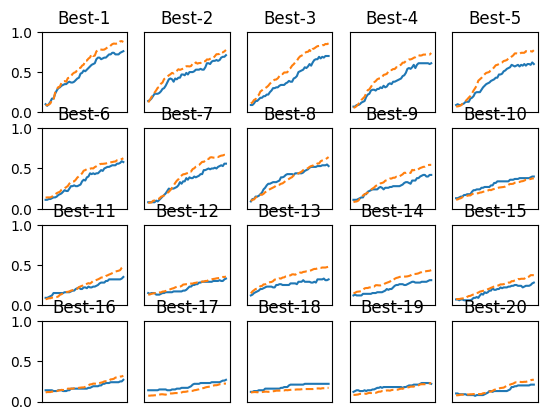

In [14]:
# coding: utf-8
import sys, os
sys.path.append(os.pardir)  # 为了导入父目录的文件而进行的设定
import numpy as np
import matplotlib.pyplot as plt
from digit_recognition.mnist import load_mnist
from common.multi_layer_net import MultiLayerNet
from common.util import shuffle_dataset
from common.trainer import Trainer

(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True)

# 为了实现高速化，减少训练数据
x_train = x_train[:500]
t_train = t_train[:500]

# 分割验证数据
validation_rate = 0.20
validation_num = int(x_train.shape[0] * validation_rate)
x_train, t_train = shuffle_dataset(x_train, t_train)
x_val = x_train[:validation_num]
t_val = t_train[:validation_num]
x_train = x_train[validation_num:]
t_train = t_train[validation_num:]


def __train(lr, weight_decay, epocs=50):
    network = MultiLayerNet(input_size=784, hidden_size_list=[100, 100, 100, 100, 100, 100],
                            output_size=10, weight_decay_lambda=weight_decay)
    trainer = Trainer(network, x_train, t_train, x_val, t_val,
                      epochs=epocs, mini_batch_size=100,
                      optimizer='sgd', optimizer_param={'lr': lr}, verbose=False)
    trainer.train()

    return trainer.test_acc_list, trainer.train_acc_list


# 超参数的随机搜索======================================
optimization_trial = 100
results_val = {}
results_train = {}
for _ in range(optimization_trial):
    # 指定搜索的超参数的范围===============
    weight_decay = 10 ** np.random.uniform(-8, -4)
    lr = 10 ** np.random.uniform(-6, -2)
    # ================================================

    val_acc_list, train_acc_list = __train(lr, weight_decay)
    print("val acc:" + str(val_acc_list[-1]) + " | lr:" + str(lr) + ", weight decay:" + str(weight_decay))
    key = "lr:" + str(lr) + ", weight decay:" + str(weight_decay)
    results_val[key] = val_acc_list
    results_train[key] = train_acc_list

# 绘制图形========================================================
print("=========== Hyper-Parameter Optimization Result ===========")
graph_draw_num = 20
col_num = 5
row_num = int(np.ceil(graph_draw_num / col_num))
i = 0

for key, val_acc_list in sorted(results_val.items(), key=lambda x:x[1][-1], reverse=True):
    print("Best-" + str(i+1) + "(val acc:" + str(val_acc_list[-1]) + ") | " + key)

    plt.subplot(row_num, col_num, i+1)
    plt.title("Best-" + str(i+1))
    plt.ylim(0.0, 1.0)
    if i % 5: plt.yticks([])
    plt.xticks([])
    x = np.arange(len(val_acc_list))
    plt.plot(x, val_acc_list)
    plt.plot(x, results_train[key], "--")
    i += 1

    if i >= graph_draw_num:
        break

plt.show()


实线是验证数据的识别精度，虚线是训练数据的识别精度
按识别精度从高到低的顺序排列了验证数据的学习的变化。从图中可知，直到“Best-5”左右，学习进行得都很顺利

观察可以使学习顺利进行的超参数的范围，从而缩小值的范围。然后，在这个缩小的范围中重复相同的操作这样就能缩小到合适的超参数的存在范围，然后在某个阶段，选择一个最终的超参数的值。